# Анализ бизнес-метрик

**Цель проекта: помочь отделу маркетинга принять обоснованное решение о направлениях оптимизации маркетинговых затрат**

Для достижения цели предстоит рещить ряд задач: рассчитать ключевые метрики, касающиеся использования продукта (DAU, WAU, MAU, число и продолжительность пользовательской сессии, Retention Rate), продаж (средний чек, LTV  на основе когортного анализа) и маркетинга (расходы на каждый из источников привлечения, САС, ROMI)



**Описание данных:**


Таблица **visits** (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


Таблица **orders** (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа


Таблица **costs** (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

**Оглавление:**

1. [Шаг 1. Загрузите данные и подготовьте их к анализу](#step1)
2. [Шаг 2. Постройте отчёты и посчитайте метрики](#step2)
 1. [Продукт](#step2a)
 2. [Продажи](#step2b)
 3. [Маркетинг](#step2c)
3. [Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?](#step3)

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

<a id="step1"></a>
### Шаг 1. Загрузите данные и подготовьте их к анализу

***Таблица visits***

In [2]:
visits = pd.read_csv('visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица содержит 359400 наблюдений, пропусков нет. В кооректировке нуждаются заголовки столбцов, а также формат столбцов End Ts и Start Ts.	

In [4]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [5]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [6]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [9]:
visits['start_ts'].min()

Timestamp('2017-06-01 00:01:00')

In [10]:
visits['end_ts'].min()

Timestamp('2017-06-01 00:02:00')

In [11]:
visits['start_ts'].max()

Timestamp('2018-05-31 23:59:00')

In [12]:
visits['end_ts'].max()

Timestamp('2018-06-01 01:26:00')

In [13]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6], dtype=int64)

Из-за того, что некоторые сессии закончились 1 июня 2018 года, группировка может быть осложнена. Определим такие сессии.

In [14]:
visits_june_2018 = visits[visits['end_ts'] >= '2018-06-01']

In [15]:
visits_june_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 2330 to 355366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   device     12 non-null     object        
 1   end_ts     12 non-null     datetime64[ns]
 2   source_id  12 non-null     int64         
 3   start_ts   12 non-null     datetime64[ns]
 4   uid        12 non-null     uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 576.0+ bytes


Их всего 12 штук. Наверное, можно от них избавиться

In [16]:
visits = visits.drop(np.where(visits['end_ts'] >= '2018-06-01')[0])

In [17]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359388 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359388 non-null  object        
 1   end_ts     359388 non-null  datetime64[ns]
 2   source_id  359388 non-null  int64         
 3   start_ts   359388 non-null  datetime64[ns]
 4   uid        359388 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [18]:
visits = visits.query('end_ts >= start_ts')

In [19]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359386 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359386 non-null  object        
 1   end_ts     359386 non-null  datetime64[ns]
 2   source_id  359386 non-null  int64         
 3   start_ts   359386 non-null  datetime64[ns]
 4   uid        359386 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


Дополнительно мы выяснили, что представленные данные охватывают период c 1 июня 2017 по 1 июня 2018 года. Мы исключили сессии, закончившиеся 1 июня 2018 года.



Пользователи заходили с двух типов устройств из 9 различных рекламных источников [ 4,  2,  5,  9,  3,  1, 10,  7,  6]. Точная расшифровка источников неизвестна


похоже, в данных было две записи с ошибкой: время окончания сессии меньше времени ее начала. мы избавились от этих записей

***Таблица orders***

In [20]:
orders = pd.read_csv('orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


таблица содержит 50415 наблюдений, пропусков нет. В кооректировке нуждаются заголовки столбцов, а также формат столбца Buy Ts 

In [22]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [23]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [25]:
orders['buy_ts'].min()

Timestamp('2017-06-01 00:10:00')

In [26]:
orders['buy_ts'].max()

Timestamp('2018-06-01 00:02:00')

Некторые заказы были сделаны 1 июня. Найдем их

In [27]:
orders_june_2018 = orders[orders['buy_ts'] >= '2018-06-01']

In [28]:
orders_june_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 50414 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   1 non-null      datetime64[ns]
 1   revenue  1 non-null      float64       
 2   uid      1 non-null      uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 32.0 bytes


Такой заказ всего 1. Исключим его, чтобы упросить группировку.

In [29]:
orders = orders.drop(np.where(orders['buy_ts'] >= '2018-06-01')[0])

In [30]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50414 non-null  datetime64[ns]
 1   revenue  50414 non-null  float64       
 2   uid      50414 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


Представленные данные охватывают период c 1 июня 2017 по 1 июня 2018 года

In [31]:
orders = orders.query('revenue >= 0')

In [32]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50414 non-null  datetime64[ns]
 1   revenue  50414 non-null  float64       
 2   uid      50414 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


похоже, данные о выручке корректны и не содержат отрицательных значений</div>

***Таблица costs*** 

In [33]:
costs = pd.read_csv('costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [34]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


таблица содержит 2542 наблюдений, пропусков нет. В кооректировке нуждается формат столбца dt. Также для большей ясности можно переименовать этот столбец в date

In [35]:
costs.columns = ['source_id', 'date', 'costs']

In [36]:
costs['date'] = pd.to_datetime(costs['date'])

In [37]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [38]:
costs['date'].min()

Timestamp('2017-06-01 00:00:00')

In [39]:
costs['date'].max()

Timestamp('2018-05-31 00:00:00')

In [40]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

Представленные данные охватывают период c 1 июня 2017 по 31 мая 2018 года. В таблице содержатся данные о расходах на рекламные источники [ 1,  2,  3,  4,  5,  9, 10]. Точная расшифровка источников неизвестна. 

### Вывод:


Мы познакомились с предоставленными нам данными, оптимизировали их представление (привели названия столбцов к строчным буквам без пробелов) и скорректировали формат даты там, где было необходимо.


Мы установлили, что таблицы visits и orders охватывают период с 1 июня 2017 по 1 июня 2018 года, а таблица costs - c 1 июня 2017 по 31 мая 2018 года. Для упрощения группировки по неделям и месяцам, мы исключили визиты и заказы, которые произошли 1 июня 2018 года


Мы установили, что пользователи заходят на сайт с устройств двух типов. Точная расшифровка типов нам неизвестна, но можно предположить, что это стационарные компьютеры (возможно, сюда же относятся ноутбуки) и устройства с тачскрином (скорее всего, телефоны и планшеты)


Еще можно заметить несовпадение списка рекламных источников в таблицах visits и costs

<a id="step2"></a>
### Шаг 2. Постройте отчёты и посчитайте метрики

<a id="step2a"></a>
#### Продукт

***Сколько людей пользуются в день, неделю, месяц?***


Выделим из даты сессии непосредственно дату, неделю и месяц. Определим среднее количество уникальных пользователей в каждый период времени

In [41]:
visits['date'] = visits['start_ts'].dt.date

In [42]:
visits['month'] = visits['start_ts'].dt.month

In [43]:
visits['week'] = visits['start_ts'].dt.week

<ipython-input-43-25a402353101>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['week'] = visits['start_ts'].dt.week


In [44]:
visits['year'] = visits['start_ts'].dt.year

In [45]:
dau = visits.groupby(['date', 'year']).agg({'uid': 'nunique'})

<AxesSubplot:title={'center':'Число активных пользователей по дням'}, xlabel='date,year'>

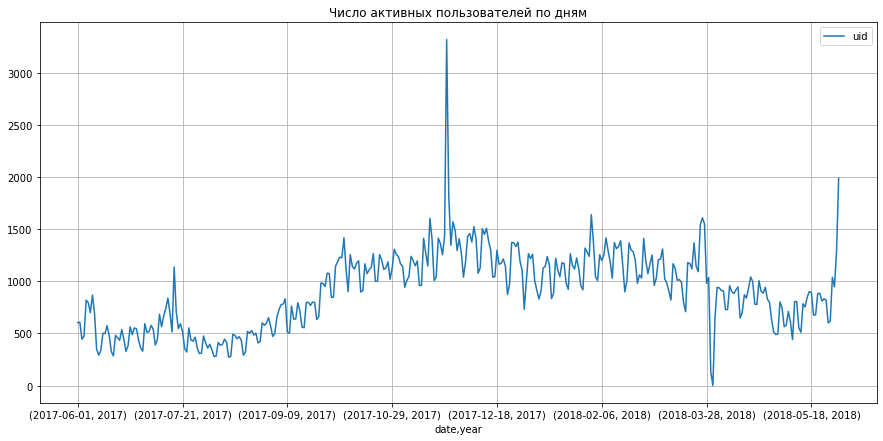

In [46]:
dau.plot(grid=True, figsize=(15, 7), title = 'Число активных пользователей по дням')

In [47]:
dau.sort_values('uid').head()

,,uid
date,year,
2018-03-31,2018,1
2018-03-30,2018,131
2017-08-12,2017,271
2017-08-05,2017,280
2017-08-13,2017,281


In [48]:
dau.sort_values('uid').tail()

,,uid
date,year,
2018-03-26,2018,1609
2018-02-01,2018,1640
2017-11-25,2017,1817
2018-05-31,2018,1988
2017-11-24,2017,3319


In [49]:
dau_total = dau.mean()

In [50]:
int(dau_total)

907

In [51]:
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'})

<AxesSubplot:title={'center':'Число активных пользователей по неделям'}, xlabel='year,week'>

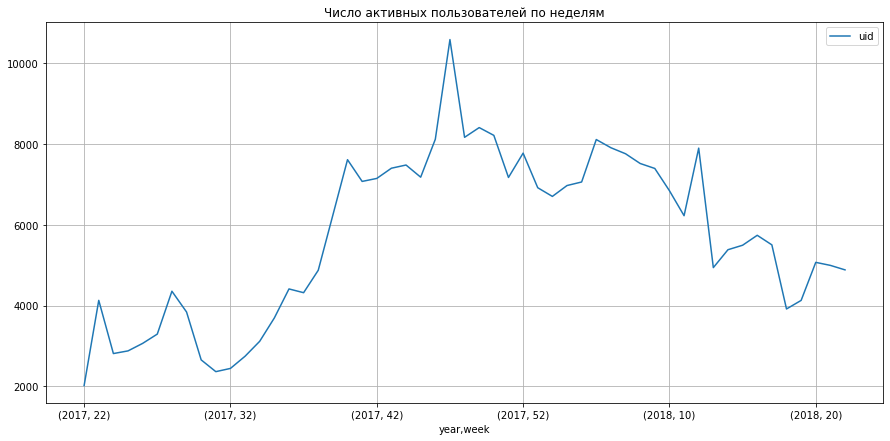

In [52]:
wau.plot(grid=True, figsize=(15, 7), title = 'Число активных пользователей по неделям')

In [53]:
wau_total = wau.mean()

In [54]:
int(wau_total)

5716

In [55]:
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'})

<AxesSubplot:title={'center':'Число активных пользователей по месяцам'}, xlabel='year,month'>

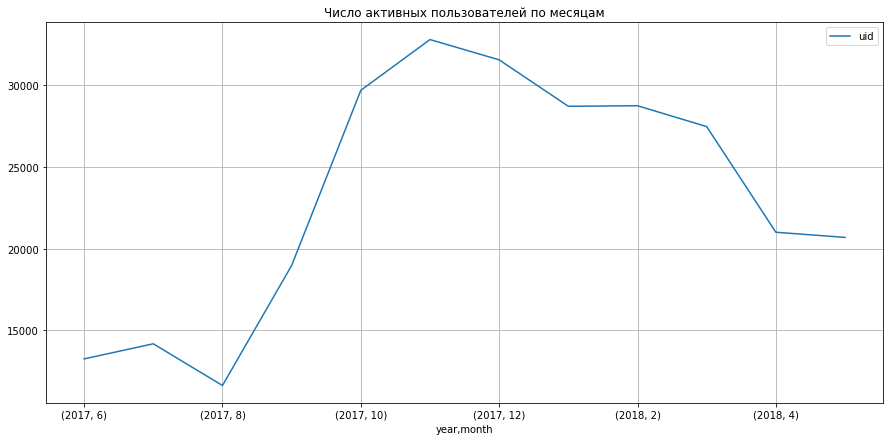

In [56]:
mau.plot(grid=True, figsize=(15, 7), title = 'Число активных пользователей по месяцам')

In [57]:
mau_total = mau.mean()

In [58]:
int(mau_total)

23227

Продукт имеет в среднем 907 уникальных пользователей в день. На графике изменения показателя dau отмечаются 2 пика: пик вниз 2018-03-31 (1 пользователь) и пик вверх 2017-11-24 (3319 пользователей)


Продукт имеет в среднем 5716 уникальных пользователей в неделю. На графике изменения показателя wau можно отметить ту же динамику, которую мы уже наблюдали: рост числа пользователей с 32 недели (это приблизиительно август), пик в ноябре-декабре 


Продукт имеет в среднем 23227 уникальных пользователей в месяц. График изменения показателя mau в целом повторяет динамику wau

In [59]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid,date,month,week,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,12,52,2017
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,9,35,2017
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,1,5,2018
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,11,44,2017
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,7,29,2017
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,11,45,2017


***Сколько сессий в день?***


Определим, сколько сессий приходится на каждого пользователя в месяц

In [60]:
sessions_per_user_monthly = visits.groupby(['month','year']).agg({'uid': ['count', 'nunique']})
sessions_per_user_monthly.columns = ['monthly_sessions', 'monthly_users']
sessions_per_user_monthly['monthly_sess_per_user'] = sessions_per_user_monthly['monthly_sessions'] / sessions_per_user_monthly['monthly_users']

In [61]:
sessions_per_user_monthly = sessions_per_user_monthly.sort_values(['year','month'])
sessions_per_user_monthly

,,monthly_sessions,monthly_users,monthly_sess_per_user
month,year,,,
6,2017,16505,13259,1.244815
7,2017,17828,14183,1.256998
8,2017,14355,11631,1.234202
9,2017,23907,18975,1.259921
10,2017,37903,29692,1.276539
11,2017,43969,32797,1.340641
12,2017,41983,31557,1.330386
1,2018,36939,28716,1.286356
2,2018,37182,28749,1.293332


<AxesSubplot:title={'center':'число сессий по месяцам'}, xlabel='month,year'>

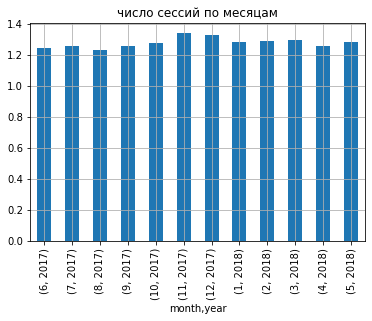

In [62]:
sessions_per_user_monthly['monthly_sess_per_user'].plot(kind = 'bar', grid = True, title = 'число сессий по месяцам')

В течение года пользователи проводили не более 1,4 сесиий в месяц на человека. Самыми активными являются месяцы с ноября по март и май. Летом пользование "Афишей" не такое активное. Это традиционное время затишья в культурной жизни. Возможно также, что пользователи покидают город на лето.

***Сколько длится одна сессия?***


Определим среднюю продолжительность сессии (ASL)

In [63]:
visits['session_duration_min'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()/60

In [64]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,year,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,12,52,2017,0.0


In [65]:
ASL = visits['session_duration_min'].mean()
ASL

10.716691431126575

<AxesSubplot:title={'center':'распределение продолжительности сессии'}, ylabel='Frequency'>

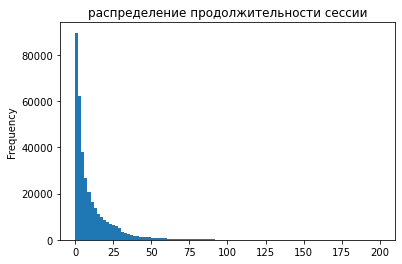

In [66]:
visits['session_duration_min'].plot(kind='hist', bins = 100, range = (0,200), title = 'распределение продолжительности сессии')


In [67]:
visits['session_duration_min'].mode()

0    1.0
dtype: float64

Итак, средняя продолжительность сессии за весь представленный период составляет 10,72 минуты. Однако распределение показателей продолжительности не является нормальным. Рассчитанное модальное значение оказалось значительно ниже среднего - всего 1 минута. 


Причину такого расхождения еще предстоит определить. Возможно, пользователи чаще всего открываю сайт, чтобы просто узнать о том, что идет в кино, театрах и клубах города или посмотреть расписание. Выяснить это можно, проследив пользовательскую активность в различных разделах сайта: от просмотра до покупки билета


Определим, как изменяется показатель ASL по месяцам

In [68]:
ASL_monthly = visits.groupby(['month', 'year']).agg({'session_duration_min':'mean'})
ASL_monthly.sort_values(['year','month'])

,,session_duration_min
month,year,
6,2017,10.000402
7,2017,10.077271
8,2017,9.818232
9,2017,9.953174
10,2017,10.241435
11,2017,11.890127
12,2017,11.577994
1,2018,10.883334
2,2018,10.752453


<AxesSubplot:title={'center':'средняя продолжительность сессии по месяцам'}, xlabel='month,year'>

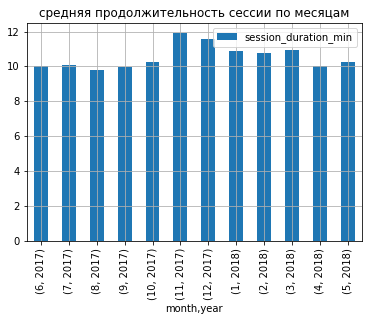

In [69]:
ASL_monthly.sort_values(['year','month']).plot(kind = 'bar', grid = True, title = 'средняя продолжительность сессии по месяцам')

Мы видим, что в месяцы высокой пользовательской активности растет не только количество сессий на одного пользователя, но и их продолжительность. 

***Как часто люди возвращаются?***


Определим, как часто пользователи обращаются к сайту (sticky factor)

In [70]:
sticky_mau = dau_total / mau_total * 100
sticky_mau

uid    3.908961
dtype: float64

In [71]:
sticky_wau = dau_total / wau_total * 100
sticky_wau

uid    15.884396
dtype: float64

Исходя из показтелей sticky factor можно сказать, что 15,6% еженедельной аудитории и 3,9% ежемесячной аудитории пользуется сайтом ежедневно

### Расчет Retention Rate

In [72]:
rr_visits = visits

In [73]:
rr_first_visit = rr_visits.groupby('uid')['start_ts'].min().reset_index()
rr_first_visit.columns = ['uid', 'first_visit']


In [74]:
rr_visits = rr_visits.merge(rr_first_visit, on='uid')
rr_visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,year,session_duration_min,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018,24.0,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,3,10,2018,28.0,2018-03-09 20:05:00


In [75]:
rr_visits['first_visit_month'] = rr_visits['first_visit'].astype('datetime64[M]')
rr_visits['visit_month'] = rr_visits['start_ts'].astype('datetime64[M]')
rr_visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,year,session_duration_min,first_visit,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018,24.0,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,3,10,2018,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01


In [76]:
rr_visits['lifetime'] = (rr_visits['visit_month'] - rr_visits['first_visit_month']) / np.timedelta64(1, 'M')
rr_visits['lifetime'] = rr_visits['lifetime'].round().astype('int')

In [77]:
rr_cohorts = rr_visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()

In [78]:
rr_cohorts.head()

,first_visit_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [79]:
init_uid = rr_cohorts[rr_cohorts['lifetime'] == 0][['first_visit_month','uid']]
init_uid.columns = ['first_visit_month', 'init_uid']

In [80]:
init_uid.head()

,first_visit_month,init_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [81]:
rr_cohorts = rr_cohorts.merge(init_uid, on='first_visit_month')

In [82]:
rr_cohorts['retention'] = rr_cohorts['uid'] / rr_cohorts['init_uid']
retention_pivot = rr_cohorts.pivot_table(index='first_visit_month',columns='lifetime',values='retention',aggfunc='sum') 

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='lifetime', ylabel='first_visit_month'>

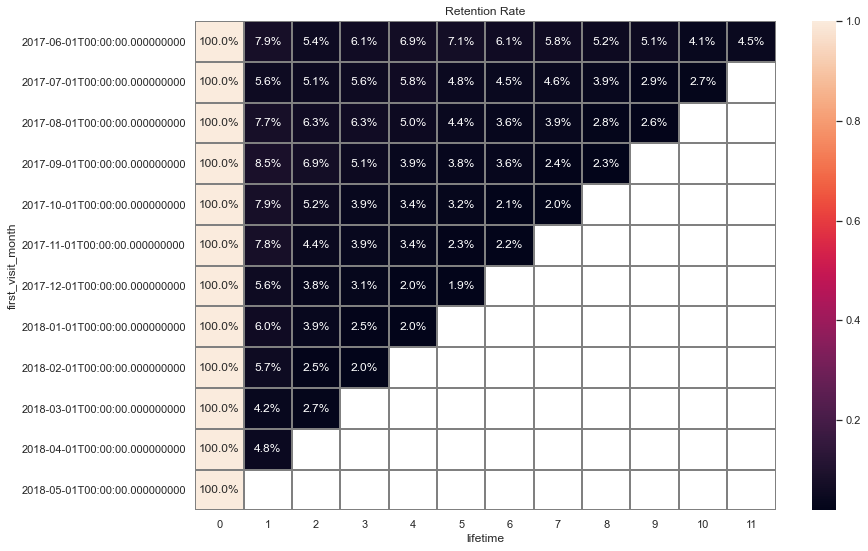

In [83]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Расчет Retention Rate еще раз демонстрирует, что более 90% посетителей заходят на сайт лишь один раз </div>

<a id="step2b"></a>
#### Продажи

***Когда люди начинают покупать?***


Определим, через какое время после первого визита пользователи совершают первую покупку на сайте. Из таблицы visits определим дату первого визита, а из таблицы orders - первой покупки

In [84]:
first_visits = visits.groupby('uid')['start_ts'].min()

In [85]:
first_visits.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

In [86]:
first_orders = orders.groupby('uid')['buy_ts'].min()

In [87]:
first_orders.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: buy_ts, dtype: datetime64[ns]

In [88]:
first_orders.name = 'first_buy_ts'

In [89]:
first_visits_orders = first_visits.to_frame().join(first_orders, how = 'inner', on = 'uid')

In [90]:
first_visits_orders['delta'] = (first_visits_orders['first_buy_ts'] - first_visits_orders['start_ts']).dt.total_seconds()/60 

In [91]:
first_visits_orders.head(10)

,start_ts,first_buy_ts,delta
uid,,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00,25.0
3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00,53222.0
3753586865891862,2018-03-03 13:47:00,2018-03-03 13:50:00,3.0
4808417689019433,2018-01-09 23:10:00,2018-01-09 23:32:00,22.0


In [92]:
first_visits_orders['delta'].mean()

24340.842204698536

<AxesSubplot:title={'center':'время от первого визита до первой покупки'}, ylabel='Frequency'>

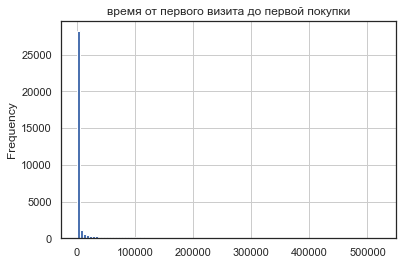

In [93]:
first_visits_orders['delta'].plot(kind = 'hist', bins=100, grid = True, title = 'время от первого визита до первой покупки')

В среднем от первого визита до перовго заказа на сайте проходит 24341 минута. Это 16,9 дня. Но распределение неравномерное. 

In [94]:
first_visits_orders['delta'].mode()

0    1.0
dtype: float64

In [95]:
first_visits_orders.describe()

,delta
count,36522.000000
mean,24340.842205
std,67785.583078
min,0.000000
25%,4.000000
50%,16.000000
75%,2897.500000
max,523144.000000


Мы опять видим модальное значение, равное 1 минуте. Это очень быстро, но может быть объяснено, например, так: пользователь щелкает на рекламу заинтересовавшего его события и сразу покупает билет, не тратя время на выбор мероприятия. Также мы можем видеть, что 25% покупок совершаются в течение 4 минут с момента захода. 50% - в течение 15 минут (здесь похоже пользователь выбирает, куда бы пойти). И 75% покупок совершаются в течение 2898 минут от момента первого визита. Это 2 дня и вероятно это время, которое требуется, чтобы обдумать готовность пойти на заинтересовавшее мероприятие (например, обсудить с друзьями поход в кино)

***Сколько раз покупают за период?***


Применим когортный анализ и определим, насколько активно пользователи совершают последующие покупки после первой

In [96]:
orders = orders.merge(first_orders, on = 'uid')

In [97]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')

In [98]:
orders['lifetime'] = (orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')
orders['lifetime'] = orders['lifetime'].round().astype('int')

In [99]:
orders.head(10)

,buy_ts,revenue,uid,first_buy_ts,buy_month,first_buy_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,0
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,0
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,0
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,0


In [100]:
cohort_grouped = orders.groupby('first_buy_month').agg({'uid':['count', 'nunique'], 'revenue':'sum'})


In [101]:
cohort_grouped.columns = ['count_uid', 'n_uid', 'revenue']

In [102]:
cohort_grouped

,count_uid,n_uid,revenue
first_buy_month,,,
2017-06-01,4438,2023,24031.69
2017-07-01,2910,1923,16127.92
2017-08-01,2188,1370,11606.26
2017-09-01,3878,2581,34676.32
2017-10-01,6005,4340,27603.45
2017-11-01,5900,4081,26098.99
2017-12-01,5894,4383,33485.74
2018-01-01,4308,3373,16663.13
2018-02-01,4470,3651,16750.50


In [103]:
orders_pivot = orders.pivot_table(index = 'first_buy_month', columns = 'lifetime', values = 'uid', aggfunc = 'nunique')
orders_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN,NaN
2017-09-01,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN,NaN,NaN
2017-10-01,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN,NaN,NaN,NaN
2017-11-01,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,4383.0,146.0,103.0,97.0,50.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3373.0,114.0,83.0,43.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3651.0,118.0,58.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Количество покупок в зависимости от lifetime'}, xlabel='lifetime', ylabel='first_buy_month'>

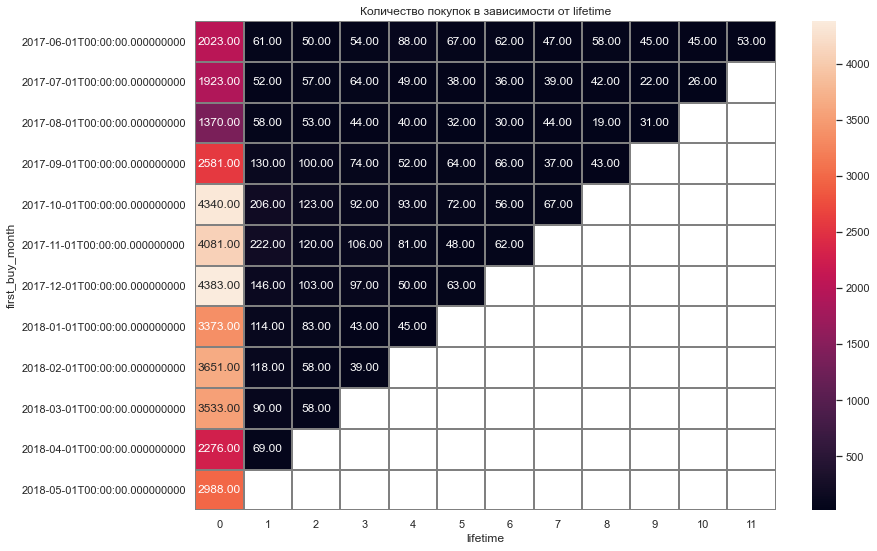

In [104]:
plt.figure(figsize=(13, 9))
plt.title('Количество покупок в зависимости от lifetime')
sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray') 

Мы видим, что активность пользователей после первой покупки очень существенно снижается. Однако надо учитывать и ту сезонность в пользовании сайтом, которую мы обнаружили ранее

In [105]:
purchases_monthly = orders.groupby('buy_month')['uid'].count()

<AxesSubplot:title={'center':'Число покупок по месяцам'}, xlabel='buy_month'>

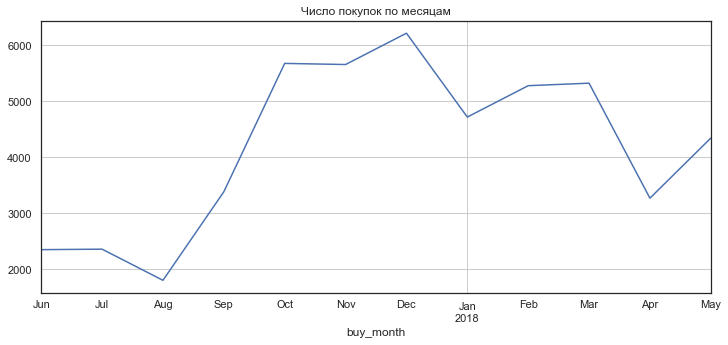

In [106]:
purchases_monthly.plot(kind='line', grid=True, title='Число покупок по месяцам', figsize=(12, 5))

In [107]:
revenue_monthly = orders.groupby('buy_month')['revenue'].sum()

<AxesSubplot:title={'center':'Выручка по месяцам'}, xlabel='buy_month'>

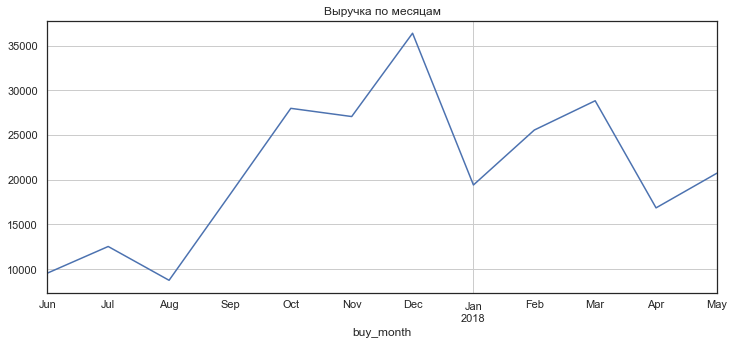

In [108]:
revenue_monthly.plot(kind='line', grid=True, title='Выручка по месяцам', figsize=(12, 5))

Число покупок и выручка по месяцам демонстрируют уже знакомую нам динамику с пиком в декабре

***Какой средний чек?***

In [109]:
orders_grouped_by_cohorts = orders.groupby(['first_buy_month','buy_month']).agg({'revenue':'sum','uid':'nunique'}).reset_index()

Определим средний чек по месяцам для каждой когорты

In [110]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

In [111]:
orders_grouped_by_cohorts.head()

,first_buy_month,buy_month,revenue,uid,revenue_per_user
0,2017-06-01,2017-06-01,9557.49,2023,4.724414
1,2017-06-01,2017-07-01,981.82,61,16.095410
2,2017-06-01,2017-08-01,885.34,50,17.706800
3,2017-06-01,2017-09-01,1931.30,54,35.764815
4,2017-06-01,2017-10-01,2068.58,88,23.506591


In [112]:
orders_grouped_by_cohorts.pivot_table(index='first_buy_month',columns='buy_month',values='revenue_per_user',aggfunc='mean') 

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026


***Визуализируем полученную таблицу при помощи тепловой карты***


Начнем с того, что определим lifetime

In [113]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['buy_month'] - orders_grouped_by_cohorts['first_buy_month']
orders_grouped_by_cohorts['cohort_lifetime'].head() 

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

Переведем в количество целых месяцев

In [114]:
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')

In [115]:
orders_grouped_by_cohorts['first_buy_month'] = orders_grouped_by_cohorts['first_buy_month'].dt.strftime('%Y-%m') 

In [116]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime', values = 'revenue_per_user', aggfunc = 'mean')

In [117]:
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Средний чек покупателей'}, xlabel='cohort_lifetime', ylabel='first_buy_month'>

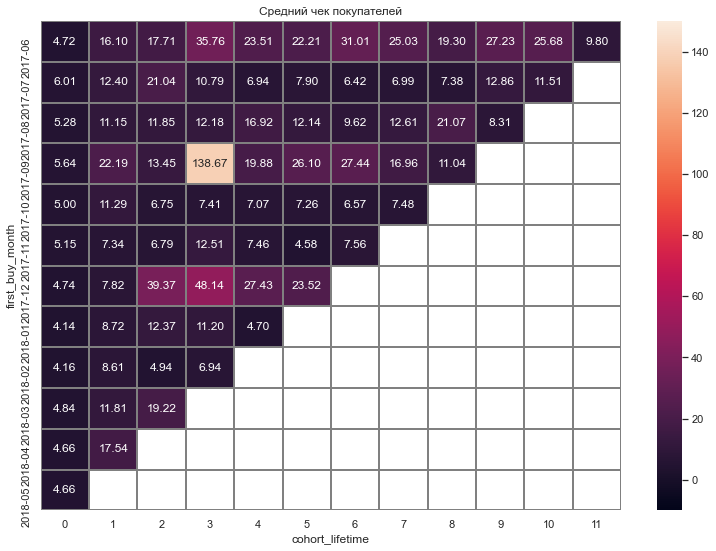

In [118]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = -10, vmax=150) 

Мы видим, что показатели среднего чека ведут себя по-разному. Нет устойчивой заметной динамики его изменения взависимости от месяца lifetime. На фоне остальных показателей среднего чека выделяется один - покупки "сентябрьской" когорты в 3 месяц lifetime (то есть в декабре). Декабрь, по нашим оценкам, относится к месяцу высокой пользовательской активности, но остается непонятным, почему в прочих когортах средний чек декабря так не выделяется

***Сколько денег приносят? (LTV)***


LTV - накопительная величина, показывающая, какую сумму приносит в среднем 1 клиент со всех своих покупок за рассматриваемый период

преобразуем таблицы cohort_grouped и orders_grouped_by_cohorts, оставив в них только необходимую информацию

In [119]:
cohort_grouped = cohort_grouped.reset_index()

In [120]:
cohorts_new = cohort_grouped[['first_buy_month', 'n_uid']]

In [121]:
cohorts_new

,first_buy_month,n_uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [122]:
cohorts_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   first_buy_month  12 non-null     datetime64[ns]
 1   n_uid            12 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 320.0 bytes


In [123]:
orders_grouped_by_cohorts.head()

,index,first_buy_month,buy_month,revenue,uid,revenue_per_user,cohort_lifetime
0,0,2017-06,2017-06-01,9557.49,2023,4.724414,0
1,1,2017-06,2017-07-01,981.82,61,16.095410,1
2,2,2017-06,2017-08-01,885.34,50,17.706800,2
3,3,2017-06,2017-09-01,1931.30,54,35.764815,3
4,4,2017-06,2017-10-01,2068.58,88,23.506591,4


In [124]:
orders_grouped_by_cohorts_new = orders_grouped_by_cohorts[['first_buy_month', 'buy_month', 'revenue']]

In [125]:
orders_grouped_by_cohorts_new.head()

,first_buy_month,buy_month,revenue
0,2017-06,2017-06-01,9557.49
1,2017-06,2017-07-01,981.82
2,2017-06,2017-08-01,885.34
3,2017-06,2017-09-01,1931.30
4,2017-06,2017-10-01,2068.58


In [126]:
orders_grouped_by_cohorts_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   first_buy_month  78 non-null     object        
 1   buy_month        78 non-null     datetime64[ns]
 2   revenue          78 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.0+ KB


In [127]:
orders_grouped_by_cohorts_new = orders_grouped_by_cohorts_new.copy()
orders_grouped_by_cohorts_new['first_buy_month'] = pd.to_datetime(orders_grouped_by_cohorts_new['first_buy_month'])

In [128]:
report = pd.merge(cohorts_new, orders_grouped_by_cohorts_new, on='first_buy_month')

In [129]:
report.head()

,first_buy_month,n_uid,buy_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Дополнительные действия и допущения:
- Добавим столбец 'age' - возраст когорты в месяцах, прошедших с момента первой покупки
- Примем маржинальность за 100% (валовая прибыль = выручке)

In [130]:
report['age'] = (report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [131]:
report['ltv'] = report['revenue'] / report['n_uid']

In [132]:
report.head()

,first_buy_month,n_uid,buy_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [133]:
result = report.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
result.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Lifetime Value'}, xlabel='age', ylabel='first_buy_month'>

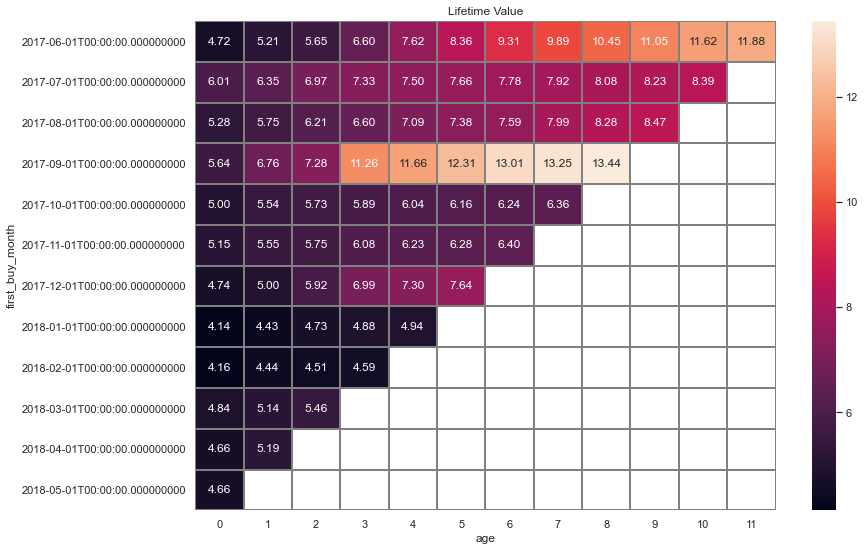

In [134]:
plt.figure(figsize=(13, 9))
plt.title('Lifetime Value')
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray') 

Мы получили величины (накопленным итогом) дохода, который в среднем приносит каждый клиент из каждой когорты. Отметим здесь "сентябрьскую" когорту, у которой, как мы помним, была большая величина среднего чека в 3 месяц lifetime. Это сказалось на величине дохода с клиента в 3 месяц по этой когорте (11.26, больше, чем в других когортах на этом этапе) и на итоговом значении для этой когорты (13.44, больше, чем в других когортах)


На первый взгляд, более "свежие" когорты приносят доход ниже в сопоставимые месяцы lifetime, но возможно это сказывается выявленная нами неравномерная пользовательская активность. Думаю, имеет смысл понаблюдать за изменением показателей данных когорт в дальнейшем

<a id="step2c"></a>
#### Маркетинг

***Сколько денег потратили? Всего / на каждый источник / по времени***

In [135]:
costs.head(10)

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [136]:
total_costs = costs['costs'].sum()
total_costs

329131.62

Общие затраты на маркетинг за рассматриваемый период составили 329131.62


Определим затраты по каждому источнику привлечения клиентов

In [137]:
costs_by_source = costs.groupby('source_id')['costs'].sum()
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

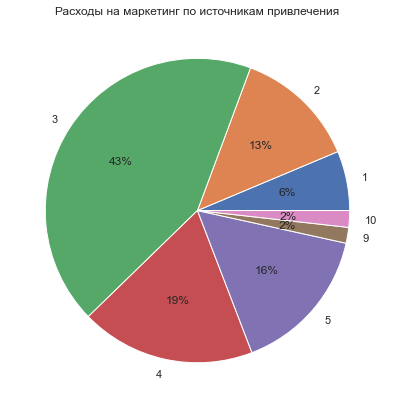

In [138]:
costs_by_source.plot(kind='pie', label='', autopct='%1.0f%%', 
        figsize=(7, 7), title='Расходы на маркетинг по источникам привлечения')
plt.show()

Круговая диаграмма демонстрирует, что больше всего расходов было связано с источником 3 (141321.63 или 43%). 

In [139]:
costs['costs_month'] = costs['date'].astype('datetime64[M]')

Определим затраты по месяцам

In [140]:
costs_by_month = costs.groupby('costs_month')['costs'].sum().reset_index()
costs_by_month

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


<AxesSubplot:xlabel='costs_month'>

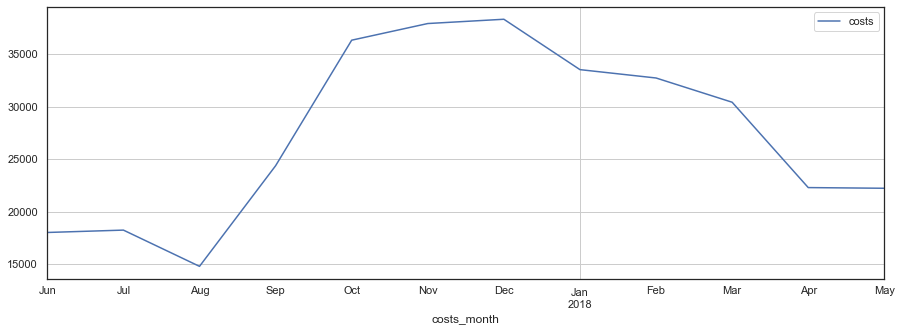

In [141]:
costs_by_month.plot(x='costs_month', y='costs', grid=True, figsize=(15,5))

Мы видим изменение общих затрат на маркетинг в течение года. Затраты быстро нарастают с августа по сентябрь и достигают пика в декабре


Рассмотрим изменение затрат в разрезе времени и источника привлечения

In [142]:
costs_by_source_month = costs.groupby(['source_id', 'costs_month'])['costs'].sum().reset_index()

In [143]:
costs_by_source_month_pivot = costs_by_source_month.pivot_table(index='costs_month', columns = 'source_id', values='costs')

<AxesSubplot:title={'center':'Затраты по месяцам и рекламным источникам'}, xlabel='costs_month'>

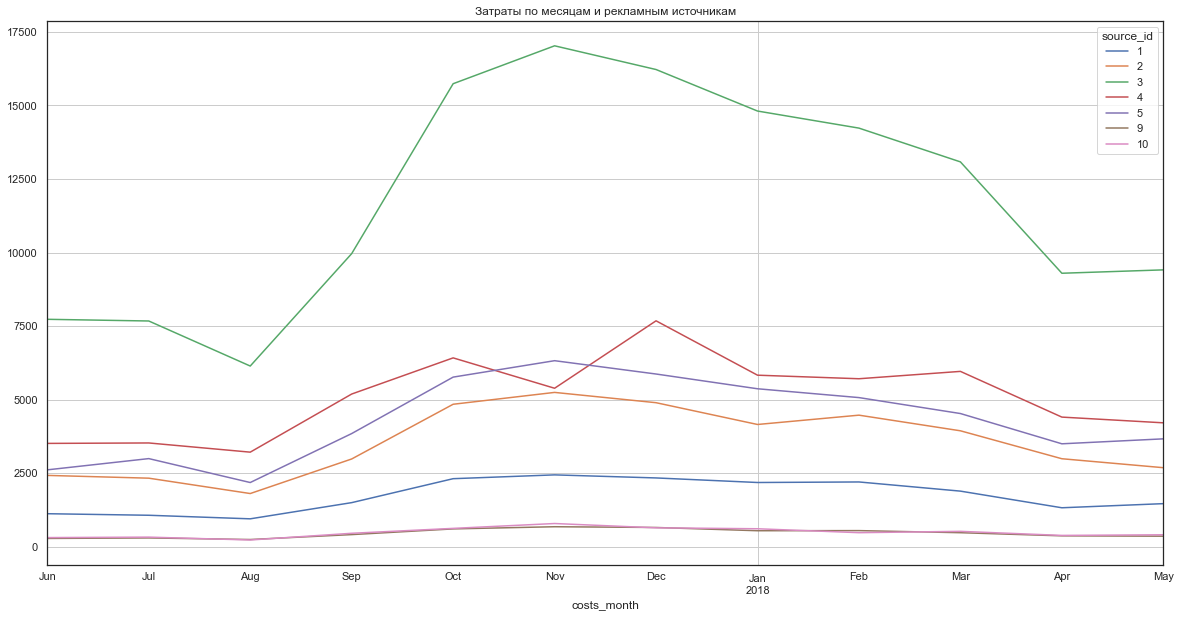

In [144]:
costs_by_source_month_pivot.plot(figsize=(20,10), title='Затраты по месяцам и рекламным источникам', grid=True)

График также дает нам понять, что источники 2, 3, 4 и 5 являются более расходными, чем 1, 9 и 10. Среди других выделяется источник 3. Самые высокие расходы по нему отмечены в ноябре

***Сколько стоило привлечение одного покупателя из каждого источника?***


Рассчитаем показатель CAC, но сделаем это не по временным когортам, а по когортам на основе рекламного источника, из которого пришел на сайт посетитель

In [145]:
costs_by_source = costs_by_source.reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [146]:
first_visits = first_visits.reset_index()
first_visits.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [147]:
first_visits.columns = ['uid', 'first_activity']

Определим источник первого визита для каждого пользователя

In [148]:
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()

In [149]:
sources.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


сгруппируем для определения количества уникальных посетителей, пришедших из того или иного источника

In [150]:
activity_source = sources.groupby('source_id')['uid'].nunique().reset_index()
activity_source

,source_id,uid
0,1,9468
1,2,17616
2,3,66115
3,4,72344
4,5,49235
5,6,2
6,7,32
7,9,6448
8,10,6902


Мы получили данные о том, сколько пользователей пришло на сайт из каждого источника. Добавим данные о расходах на источники. При предварительном изучении данных мы установили, что перечни источников в столбцах visits и costs не совпадают. Соединим таблицы так, чтобы в итоговой таблице остались те источники привлечения, расходы на которые нам известны

In [151]:
activity_source = activity_source.merge(costs_by_source, on = 'source_id', how = 'right')


In [152]:
activity_source 

,source_id,uid,costs
0,1,9468,20833.27
1,2,17616,42806.04
2,3,66115,141321.63
3,4,72344,61073.60
4,5,49235,51757.10
5,9,6448,5517.49
6,10,6902,5822.49


In [153]:
activity_source['cac'] = activity_source['costs'] / activity_source['uid']
activity_source

,source_id,uid,costs,cac
0,1,9468,20833.27,2.200388
1,2,17616,42806.04,2.429952
2,3,66115,141321.63,2.137512
3,4,72344,61073.60,0.844211
4,5,49235,51757.10,1.051226
5,9,6448,5517.49,0.855690
6,10,6902,5822.49,0.843595


<AxesSubplot:title={'center':'Стоимость привлечения 1 клиента в зависимости от рекламного источника'}, xlabel='source_id'>

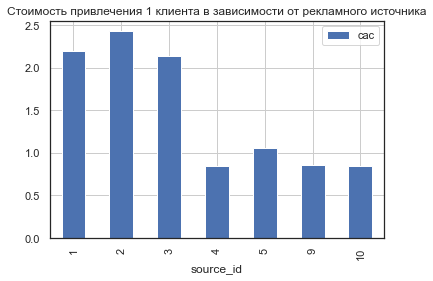

In [154]:
activity_source.plot(kind = 'bar', x= 'source_id', y='cac', grid=True, title='Стоимость привлечения 1 клиента в зависимости от рекламного источника')

Небольшое наблюдение, которое можно сделать из полученного графика: стоимость привлечения в расчете на 1 клиента из источника 3 (напомним, что на него было израсходовано 43% рекламного бюджета) оказалась одной из самых высоких. 

*С другой стороны, можно определить, сколько стоило привлечение из каждого источника тех посетитлей, которые впоследствие совершали покупки. Необходимо установить источник первого визита для каждого покупателя, информация о котором имеется в таблице orders. Затем подсчитать количество покупателей в зависимости от источника*

In [155]:
orders_first_source = orders.merge(sources, on = 'uid')

In [156]:
orders_first_source.head()

,buy_ts,revenue,uid,first_buy_ts,buy_month,first_buy_month,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


In [157]:
buyers_by_source = orders_first_source.groupby('source_id')['uid'].nunique().reset_index()

In [158]:
buyers_by_source

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1329


Мы получили данные о том, сколько покупателей пришло на сайт из каждого источника. Добавим данные о расходах на источники. При предварительном изучении данных мы установили, что перечни источников в столбцах visits и costs не совпадают. Соединим таблицы так, чтобы в итоговой таблице остались те источники привлечения, расходы на которые нам известны

In [159]:
buyers_by_source_new = buyers_by_source.merge(costs_by_source, on = 'source_id', how = 'right')

In [160]:
buyers_by_source_new

,source_id,uid,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10295,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


In [161]:
buyers_by_source_new['cac'] = buyers_by_source_new['costs'] / buyers_by_source_new['uid']
buyers_by_source_new

,source_id,uid,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10295,61073.60,5.932356
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


<AxesSubplot:title={'center':'Стоимость привлечения 1 покупателя в зависимости от рекламного источника'}, xlabel='source_id'>

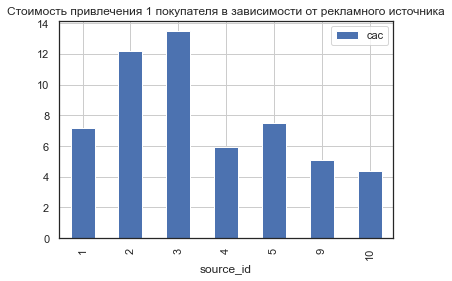

In [162]:
buyers_by_source_new.plot(kind = 'bar', x= 'source_id', y='cac', grid=True, title='Стоимость привлечения 1 покупателя в зависимости от рекламного источника')

В отношении покупателей тоже можно отметить, что самым дорогим остается источник привлечения №3

***Насколько окупились расходы? (ROI)***


Насколько же оправданными являются траты на маркетинг? Для ответа на этот вопрос предварительно нужно определить ltv для каждого источника привлечения 

In [163]:
orders_first_source.head()

,buy_ts,revenue,uid,first_buy_ts,buy_month,first_buy_month,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


для получения когорт сгруппируем данные таблицы заказов по lifetime и источнику первого привлечения клиента

In [164]:
cohorts_by_source = orders_first_source.groupby(['source_id','lifetime']).agg({'revenue': 'sum'}).reset_index()
cohorts_by_source.head()

,source_id,lifetime,revenue
0,1,0,18103.37
1,1,1,2671.98
2,1,2,2282.85
3,1,3,2110.42
4,1,4,1172.91


In [165]:
report_by_source = cohorts_by_source.merge(buyers_by_source, on='source_id')


принимаем маржинальность за 100%


поскольку признаком построения когорт в данном случае не является дата первой покупки, то определение возраста когорты, на мой взгляд, не имеет смысла

In [166]:
report_by_source['ltv'] = report_by_source['revenue'] / report_by_source['uid']
report_by_source.head()

,source_id,lifetime,revenue,uid,ltv
0,1,0,18103.37,2899,6.244695
1,1,1,2671.98,2899,0.921690
2,1,2,2282.85,2899,0.787461
3,1,3,2110.42,2899,0.727982
4,1,4,1172.91,2899,0.404591


In [167]:
output_by_source = report_by_source.pivot_table(
        index='source_id', 
        columns='lifetime', 
        values='ltv')
output_by_source.fillna(0) 

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244695,0.921690,0.787461,0.727982,0.404591,0.252856,0.257541,0.366192,0.328051,0.193846,0.130179,0.109493
2,6.610839,1.418132,1.606458,1.613072,0.700904,0.531497,0.366184,0.197239,0.132068,0.065727,0.112641,0.029042
3,4.488594,0.269803,0.145176,0.098643,0.071052,0.047545,0.027012,0.024853,0.018674,0.007186,0.004431,0.001960
4,4.555394,0.186847,0.095655,0.131625,0.100648,0.110222,0.172326,0.040403,0.019051,0.039305,0.052005,0.003406
5,4.840905,0.252398,0.205768,1.500703,0.198263,0.243675,0.126060,0.086237,0.050838,0.068039,0.013210,0.006462
7,1.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,3.892509,0.282528,0.277298,0.222371,0.142941,0.127849,0.108575,0.082252,0.131415,0.017233,0.008594,0.000000
10,3.163792,0.065064,0.027442,0.038661,0.017938,0.010000,0.008412,0.012265,0.002528,0.002528,0.000000,0.000000


посчитаем ltv накопленным итогом

In [168]:
output_by_source_cmltv = output_by_source.cumsum(axis = 1)
output_by_source_cmltv

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244695,7.166385,7.953846,8.681828,9.086419,9.339276,9.596816,9.963008,10.291059,10.484905,10.615085,10.724577
2,6.610839,8.028970,9.635428,11.248500,11.949404,12.480901,12.847085,13.044324,13.176392,13.242119,13.354760,13.383802
3,4.488594,4.758397,4.903573,5.002216,5.073268,5.120814,5.147826,5.172679,5.191353,5.198539,5.202970,5.204931
4,4.555394,4.742241,4.837896,4.969521,5.070169,5.180391,5.352718,5.393121,5.412172,5.451477,5.503482,5.506888
5,4.840905,5.093303,5.299071,6.799773,6.998036,7.241711,7.367771,7.454008,7.504846,7.572886,7.586096,7.592558
7,1.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945496,5.054072,5.136324,5.267739,5.284972,5.293566,NaN
10,3.163792,3.228856,3.256298,3.294959,3.312897,3.322897,3.331309,3.343574,3.346102,3.348631,NaN,NaN


добавим в отчет данные о стоимости привлечения 1 покупателя в зависимости от рекламного источника

In [169]:
romi_report = report_by_source.merge(buyers_by_source_new, on='source_id')
romi_report.head()

,source_id,lifetime,revenue,uid_x,ltv,uid_y,costs,cac
0,1,0,18103.37,2899,6.244695,2899,20833.27,7.186364
1,1,1,2671.98,2899,0.921690,2899,20833.27,7.186364
2,1,2,2282.85,2899,0.787461,2899,20833.27,7.186364
3,1,3,2110.42,2899,0.727982,2899,20833.27,7.186364
4,1,4,1172.91,2899,0.404591,2899,20833.27,7.186364


In [170]:
romi_report['romi'] = romi_report['ltv'] / romi_report['cac']
romi_report.head()

,source_id,lifetime,revenue,uid_x,ltv,uid_y,costs,cac,romi
0,1,0,18103.37,2899,6.244695,2899,20833.27,7.186364,0.868964
1,1,1,2671.98,2899,0.921690,2899,20833.27,7.186364,0.128255
2,1,2,2282.85,2899,0.787461,2899,20833.27,7.186364,0.109577
3,1,3,2110.42,2899,0.727982,2899,20833.27,7.186364,0.101300
4,1,4,1172.91,2899,0.404591,2899,20833.27,7.186364,0.056300


посчитаем romi накопленным итогом

In [171]:
romi_output = romi_report.pivot_table(
        index='source_id', 
        columns='lifetime', 
        values='romi')

romi_output.cumsum(axis=1)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.868964,0.997220,1.106797,1.208097,1.264397,1.299583,1.335420,1.386377,1.432026,1.459000,1.477115,1.492351
2,0.541456,0.657607,0.789183,0.921301,0.978708,1.022240,1.052232,1.068387,1.079204,1.084587,1.093813,1.096191
3,0.332639,0.352633,0.363392,0.370702,0.375968,0.379491,0.381493,0.383335,0.384718,0.385251,0.385579,0.385725
4,0.767890,0.799386,0.815510,0.837698,0.854664,0.873244,0.902292,0.909103,0.912314,0.918940,0.927706,0.928280
5,0.648265,0.682064,0.709620,0.910585,0.937135,0.969766,0.986648,0.998196,1.005004,1.014115,1.015884,1.016750
9,0.767568,0.823280,0.877961,0.921810,0.949997,0.975208,0.996618,1.012837,1.038751,1.042150,1.043844,NaN
10,0.722145,0.736996,0.743259,0.752084,0.756178,0.758461,0.760381,0.763180,0.763757,0.764335,NaN,NaN


<AxesSubplot:title={'center':'ROMI по источникам'}, xlabel='lifetime', ylabel='source_id'>

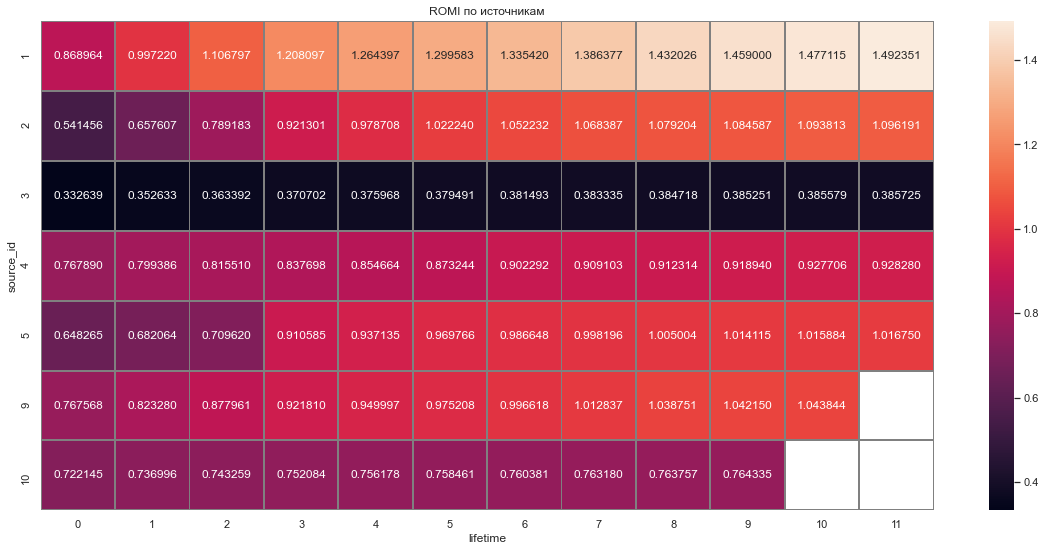

In [172]:
plt.figure(figsize=(20, 9))
plt.title('ROMI по источникам')
sns.heatmap(romi_output.cumsum(axis=1), annot=True, fmt='.6f', linewidths=1, linecolor='gray') 

Мы видим, что в течение года окупились маркетинговые затраты на источники №№1,2,5 и 9. Источник №3 не только оказался самым дорогим, но и не окупил понесенных затрат. Лучший результат по окупаемости затрат показал источник №1. Расходы на него окупились уже на 2 месяц lifetime

***Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?***

Посмотрим, как выручка зависит от типа устройства, которым пользуется покупатель, и рекламного источника

In [173]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,year,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,12,52,2017,0.0


In [174]:
orders_first_source.head()

,buy_ts,revenue,uid,first_buy_ts,buy_month,first_buy_month,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


In [175]:
device_first_source = orders_first_source.merge(visits[['device', 'uid', 'session_duration_min']] , on='uid')

In [176]:
device_first_source.head()

,buy_ts,revenue,uid,first_buy_ts,buy_month,first_buy_month,lifetime,source_id,device,session_duration_min
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1,desktop,2.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2,desktop,11.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2,desktop,9.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2,desktop,19.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3,desktop,28.0


In [177]:
revenue_by_device_and_source = device_first_source.groupby(['source_id', 'device']).agg({'revenue':'sum'}).reset_index()


In [178]:
revenue_by_device_and_source

,source_id,device,revenue
0,1,desktop,1857396.78
1,1,touch,227856.29
2,2,desktop,2081834.57
3,2,touch,146815.08
4,3,desktop,268730.57
5,3,touch,40428.15
6,4,desktop,592215.86
7,4,touch,75729.10
8,5,desktop,1591465.19
9,5,touch,17103.46


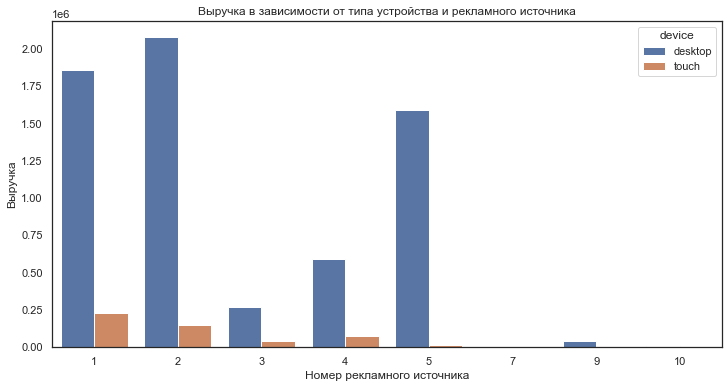

In [179]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_device_and_source)
plt.title('Выручка в зависимости от типа устройства и рекламного источника')
ax.set_xlabel('Номер рекламного источника')
ax.set_ylabel('Выручка')
plt.show()

Посмотрим, как средняя продолжительность пользовательской сессии зависит от типа устройства и рекламного источника

In [180]:
duration_by_device_and_source = device_first_source.groupby(['source_id', 'device']).agg({'session_duration_min':'mean'}).reset_index()

In [181]:
duration_by_device_and_source 

,source_id,device,session_duration_min
0,1,desktop,20.381669
1,1,touch,23.657284
2,2,desktop,23.384316
3,2,touch,19.654447
4,3,desktop,20.435334
5,3,touch,11.938536
6,4,desktop,17.265527
7,4,touch,12.406127
8,5,desktop,21.376396
9,5,touch,10.923374


Мы видим, что время сессии у источника №7 значительно превышает другие значения, но мы помним, что из него пришел к нам 1 покупатель. Исключим источник №7

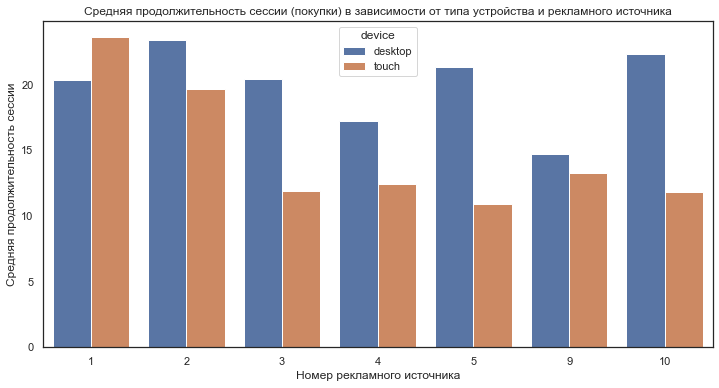

In [182]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x="source_id", y="session_duration_min", hue="device", data=duration_by_device_and_source.query("source_id != 7"))
plt.title('Средняя продолжительность сессии (покупки) в зависимости от типа устройства и рекламного источника')
ax.set_xlabel('Номер рекламного источника')
ax.set_ylabel('Средняя продолжительность сессии')
plt.show()

посмотрим, сколько уникальных пользователей заходит сайт по месяцам с устройств разного типа

In [183]:
visits_by_device_month = visits.groupby(['year', 'month', 'device']).agg({'uid':'nunique'}).reset_index()

In [184]:
visits_by_device_month

,year,month,device,uid
0,2017,6,desktop,9761
1,2017,6,touch,3655
2,2017,7,desktop,10145
3,2017,7,touch,4223
4,2017,8,desktop,8611
5,2017,8,touch,3132
6,2017,9,desktop,13509
7,2017,9,touch,5679
8,2017,10,desktop,21286
9,2017,10,touch,8856


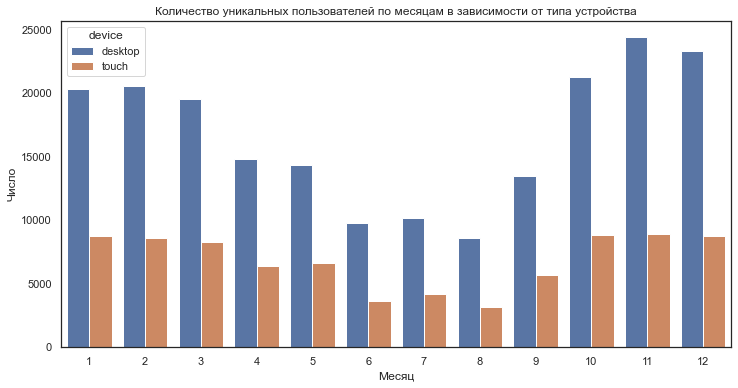

In [185]:
plt.figure(figsize = (12, 6))
#order = ['6', '7', '8', '9', '10','11','12','1','2','3','4','5']
ax = sns.barplot(x="month", y="uid", hue="device", data=visits_by_device_month)
plt.title('Количество уникальных пользователей по месяцам в зависимости от типа устройства')
ax.set_xlabel('Месяц')
ax.set_ylabel('Число')
plt.show()

<a id="step3"></a>
### Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

Основные выводы, которые можно сделать на основе проведенного исследования:


1. Продукт имеет в среднем 907 уникальных пользователей в день, 5825 - в неделю и 23227 в месяц. 
2. В течение года пользователи проводили не более 1,4 сесиий в месяц на человека. Самыми активными являются месяцы с ноября по март и май. Летом пользование "Афишей" не такое активное. Это традиционное время затишья в культурной жизни. Возможно также, что пользователи покидают город на лето.
3. Средняя продолжительность сессии за весь представленный период составляет 10,72 минуты. В месяцы высокой активности (ноябрь) продолжительность возрастает до 11,89 мин., а в месяцы низкой активности (август) снижается до 9,81 мин.
4. Исходя из показтелей sticky factor можно сказать, что 15,6% еженедельной аудитории и 3,9% ежемесячной аудитории пользуется сайтом ежедневно. Retention Rate довольно низкий для всех временных когорт. Более 90% посетителей пользуются сайтом 1 раз
5. В среднем от первого визита до перовго заказа на сайте проходит 24341 минута. Это 16,9 дня. Также мы можем видеть, что 25% покупок совершаются в течение 4 минут с момента захода. 50% - в течение 15 минут (здесь похоже пользователь выбирает, куда бы пойти). И 75% покупок совершаются в течение 2898 минут от момента первого визита. Это 2 дня и вероятно это время, которое требуется, чтобы обдумать готовность пойти на заинтересовавшее мероприятие (например, обсудить с друзьями поход в кино)
6. Мы видим, что активность пользователей после первой покупки очень существенно снижается. Большинство пользователей не возвращается на сайт после совершения первой покупки. Может ли это означать, что пользователи не хотят регистрироваться на сайте и просто совершают покупку без регистрации?
7. показатели среднего чека ведут себя по-разному. Нет устойчивой заметной динамики его изменения взависимости от сезонности или месяца lifetime.
8. Самым дорогим рекламным источником оказался источник №3 (на него приходится 43% рекланого бюджета, он самый дорогой в расчете на 1 покупателя(13,49) и один из самых дорогих в расчете на 1 посетителя (2,13))
9. В течение года окупились маркетинговые затраты на источники №№1,2,5 и 9. Источник №3 не только оказался одним из самых дорогих, но и не окупил понесенных затрат. Лучший результат по окупаемости затрат показал источник №1
10. В настоящий момент тип устройства desktop приносит больше выручки при любом рекламном истчонике, чем тип устройства touch
11. С другой стороны, пользовательские сессии, окончившиеся покупкой, для тачскринов короче, чем для десктопов. Пользователи быстрее совершают нужные действия. Либо заходят с конкретной целью. 


Рекомендации:
1. Обратить внимание на одноразовость покупателей
2. Представляется, что устройства с тачскрином имеют потенциал роста. На первый взгляд кажется, что приносимая ими выручка очень мала по сравнению с тем, насколько активно в современном мире люди пользуются носимыми гаджетами. Возможно, что-то не так с мобильной версией сайта. 
3. Что касается рекалмных источников, то можно рекомендовать внимательно изучить странный источник №7, из которого пришел лищь 1 покупатель, но нам неизвестны расходы на этот источник
4. Также можно рекоментовать внимательно изучить исчтоник №3. На него расходуется огромная доля бюджета, но по показателям окупаемости он на последнем месте. С другой стороны, именно из этого источника пришло максимальное чсило покупателей (10473). Причина низкой окупаемости этого источника может быть в дороговизне его использования и в том, что пришедшие из него покупатели тратят мало. Над этими показателями и нужно работать
5. Хорошие показатели окупаемости у источников 1,2,5 и 9. Количество привлеченных покупателей у этих источников не очень велико, но зато выручка от них существенная, а расходы на использование этих источников умеренные. 
6. Еще можно рекомендовть обратить внимание на источник №4. Он интересен тем, что из него пришло максимальное число посетителей (72344), почти столько же покупателей, сколько из самого дорогого источника №3 (10295), у него умеренный бюджет (20% от общих расходов), одни из самых низких показателей сас в расчете на посетителя и покупателя. И он почти окупился (romi = 0.93). Вероятно, у этого исчтоника может быть потенциал роста